In [1]:
import os
import pickle
import numpy as np
import random
import cv2
%matplotlib inline 
from matplotlib import pyplot as plt

In [2]:
path = "data/"

In [3]:
## preprocessing funtion
def loadbatch(batchFileName):
        ''' 
        This function load batch data from dataset 
        And return data and its label
        '''
        # load from data folder
        #path ="../input/cifar-data/data/"
        #path ="data/"
        
        file = os.path.join(path, batchFileName)
        with open(file, 'rb') as batch:
            batch = pickle.load(batch, encoding="bytes")

        data = batch[b'data']
        if (batchFileName == "data_batch_1") or (batchFileName == "data_batch_2") or \
        (batchFileName == "data_batch_3") or (batchFileName == "data_batch_4") or \
        (batchFileName == "data_batch_5") or (batchFileName == "test_batch"):
            # reshape data into (None,32,32,3)
            data = data.reshape([len(data), 3, 32, 32])
            data = data.transpose(0, 2, 3, 1)

        labels = batch[b'labels']

        return data, labels

def get_label_names():
        ''' function to read label name from batch.meta '''
        path = "./data/"
        file = os.path.join(path, "batches.meta")
        with open(file, 'rb') as F:
            meta = pickle.load(F)
        label_names = meta["label_names"]
        return label_names

# 1. Image Transformation

In [4]:
# Function for image transformation
#----------------------------------------------
# 1.rotation
def trans(point, matrix):
        # this function perform rotation of a point in co-ordinate
        return np.round(np.dot(matrix, point))

def rotate(image):
        # this function rotate image at random angle between -180 to 180

        # make new blank image
        new_image = np.zeros(image.shape, dtype='u1')
        # height, weight of image
        height = image.shape[0]
        weight = image.shape[1]
        
        # get random angle
        angle = random.randrange(-180, 180, 1) * (np.pi / 180)

        # matrix for ratation
        Rotation_matrix = np.array([[np.cos(angle), np.sin(angle)],
                                    [-np.sin(angle), np.cos(angle)]])
        # center of image as rotation axis
        center = np.array([[height / 2 - 1], [weight / 2 - 1]])

        # rotate image pixel by pixel
        for h in range(height):
            for w in range(weight):
                point = np.array([[w], [h]])
                new_loc = trans(point - center, Rotation_matrix) + center
                new_w, new_h = int(new_loc[0][0]), int(new_loc[1][0])

                if (0 <= new_w < weight) and (0 <= new_h < height):
                    new_image[new_w, new_h] = image[w, h]

        # fix missing pixel problem by taking avg of neighboring pixel
        for h in range(height):
            for w in range(weight):
                if (new_image[h, w] == 0).all():
                    s = np.array([0, 0, 0])
                    c = 0
                    if 0 <= h + 1 < height:
                        s += new_image[h + 1, w]
                        c += 1
                        if 0 <= w - 1 < weight:
                            s += new_image[h + 1, w - 1]
                            c += 1
                        if 0 <= w + 1 < weight:
                            s += new_image[h + 1, w + 1]
                            c += 1

                    if 0 <= w - 1 < weight:
                        s += new_image[h, w - 1]
                        c += 1
                    if 0 <= w + 1 < weight:
                        s += new_image[h, w + 1]
                        c += 1

                    if 0 <= h + 1 < height:
                        s += new_image[h - 1, w]
                        c += 1
                        if 0 <= w - 1 < weight:
                            s += new_image[h - 1, w - 1]
                            c += 1
                        if 0 <= w + 1 < weight:
                            s += new_image[h - 1, w + 1]
                            c += 1
                    new_image[h, w] = (s / 8).astype(np.int32)

        return new_image
#--------------------------------------------------------------------
# 2 Random block cut
def cutout(image):
        # This function cut random block from image

        # select random point and random size of block
        x = random.randrange(0, 32, 1)
        y = random.randrange(0, 32, 1)
        s = random.randrange(0, 16, 1)

        # set block to zero 
        for i in range(s):
            for j in range(s):
                if (0 <= i + y <= 32 - 1) and (0 <= j + x <= 32 - 1):
                        image[i + y, j + x] = 0

        return image

#--------------------------------------------------------------------
# 3 padding
def crop(image):
        # create new blank image
        new_image = np.zeros(image.shape, dtype='u1')
        # insert 2 pix padding 
        image_padding = np.insert(image, (0, 0, 32, 32), 0, axis=1)
        image_padding = np.insert(image_padding, (0, 0, 32, 32), 0, axis=0)
        # select random place to crop image
        x = random.randrange(0, 5, 1)
        y = random.randrange(0, 5, 1)

        for h in range(32):
            for w in range(32):
                new_image[h, w] = image_padding[h + y, w + x]
        return new_image

#--------------------------------------------------------------------
# 4.Contrast
def contrast(image):
        # this function set random Contrast in range(0.5,2) and randomly flip image
        a = random.uniform(0.5, 2)
        new_image = np.zeros(image.shape, dtype='u1')

        # height, weight of image
        height, weight = image.shape[0], image.shape[1]
        for h in range(height):
            for w in range(weight):
                r = (a * ((image[h, w, 0]) - 128) + 128)
                g = (a * ((image[h, w, 1]) - 128) + 128)
                b = (a * ((image[h, w, 2]) - 128) + 128)
                
                # correct pixel value between (0-255)
                if r > 255:
                    r = 255
                elif r < 0:
                    r = 0
                    
                if g > 255:
                    g = 255
                elif g < 0:
                    g = 0
                    
                if b > 255:
                    b = 255
                elif b < 0:
                    b = 0
            
                image[h, w, 0] = r
                image[h, w, 1] = g
                image[h, w, 2] = b
                
                
        if random.choice([True, False]):
            for h in range(32):
                for w in range(32):
                    new_image[h, 31 - w] = image[h, w]
        else:
            new_image = np.copy(image)

        return new_image

In [5]:
# load data from dataset
# image - (N,32,32,3);    labels - (N,)
data_1, labels_1 = loadbatch("data_batch_1")
data_2, labels_2 = loadbatch("data_batch_2")
data_3, labels_3 = loadbatch("data_batch_3")
data_4, labels_4 = loadbatch("data_batch_4")
data_5, labels_5 = loadbatch("data_batch_5")
test_data, test_labels = loadbatch("test_batch")

In [6]:
# for batch 1
label, counts = np.unique(labels_1, return_counts=True)
print("Batch 1")
print("Number of images per batch : {}".format(len(data_1)))
print("image shape : {}".format(data_1[0].shape))
print("count per class:")
print(dict(zip(label, counts)))

Batch 1
Number of images per batch : 10000
image shape : (32, 32, 3)
count per class:
{0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}


### 1.1 Demonstrate each transformation method

In [7]:
def display(a):
    # funtion to display image
    plt.imshow(a)
    plt.show()

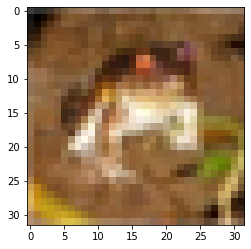

In [8]:
image = data_1[0]
# Original Image
display(image)

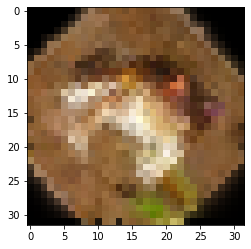

In [9]:
# 1 Rotation
rotated_image = rotate(np.copy(image))
display(rotated_image)

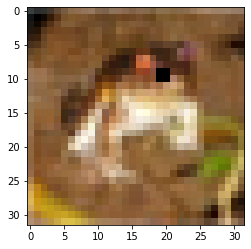

In [10]:
# Random block cut
rotated_image = cutout(np.copy(image))
display(rotated_image)

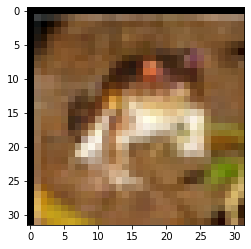

In [11]:
# padding and crop image 
rotated_image = crop(np.copy(image))
display(rotated_image)

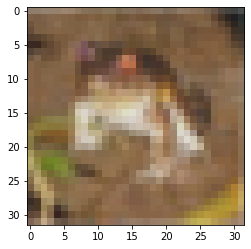

In [12]:
# contrast and flip image
rotated_image = contrast(np.copy(image))
display(rotated_image)

# 2. Create augmented training set

In [ ]:
# for every batch
for i,l,n in[(data_1,labels_1,1), (data_2,labels_2,2) ,(data_3,labels_3,3),(data_4,labels_4,4),(data_5,labels_5,5)]:
    # make copy
    x = np.copy(i)
    y = np.copy(l)

    
    for j in range(len(i)):
        print(j,end="\r")
        # select tranformation at ramdom
        transformation = random.choices([rotate,cutout,crop,contrast])[0]
        image = transformation( np.copy( i[j] ) )
        
        
        
        # add image in augmented set
        x = np.append(x, np.array([image]), axis=0)
        y = np.append(y,l[j])
        
    # save in dictionary
    Dict = {b"data": x, b"labels": y}
    filename = "aug_batch_" + str(n)
    full_path = path + filename
    #path = filename    
    with open(full_path, 'wb') as file:
        pickle.dump(Dict,file)
    

In [14]:
# read augmented batch
aug_data_1, aug_labels_1 = loadbatch("aug_batch_1")
aug_data_2, aug_labels_2 = loadbatch("aug_batch_2")
aug_data_3, aug_labels_3 = loadbatch("aug_batch_3")
aug_data_4, aug_labels_4 = loadbatch("aug_batch_4")
aug_data_5, aug_labels_5 = loadbatch("aug_batch_5")

# 3. Feature Extraction

### 3.1 Function for feature extraction

In [16]:
from feature_extractor import BBResNet18 
fe = BBResNet18()

def feature_extraction(data):
    data = np.array([cv2.resize(data[i],(224,224)) for i in range(len(data))])
    data = data.transpose([0, 3, 1, 2])
    data = data.astype(np.float32)
    data = fe.feature_extraction(data)
    return data.T

def genrate_feature_vector(X,Y):
    a = []
    # genrate feature for one image at a time
    for i in range(1,X.shape[0]+1):
        data = feature_extraction(X[i-1:i])
        a.append(data)

    # convert image in proper shape
    a = np.array(a)
    X = a.transpose([2,1,0])
    X = X[0].T
    Y = np.array(Y)
    return X, Y


### 3.2 Extract feature for augmented and unaugmented training data and test data.

In [ ]:
# combine training data
X_train = np.concatenate((data_1,data_2,data_3,data_4,data_5), axis=0)
Y_train = np.concatenate((labels_1,labels_2,labels_3,labels_4,labels_5), axis=0)

# combine augmented training data
X_train_aug = np.concatenate((aug_data_1,aug_data_2,aug_data_3,aug_data_4,aug_data_5), axis=0)
Y_train_aug = np.concatenate((aug_labels_1,aug_labels_2,aug_labels_3,aug_labels_4,aug_labels_5), axis=0)

# test data
X_test, Y_test = test_data, test_labels



# normalized data
X_train = X_train / 255 
X_train_aug = X_train_aug / 255 
X_test = X_test / 255 
Y_test = np.array(Y_test)

# feature extraction
X_train,Y_train = genrate_feature_vector(X_train,Y_train)
X_train_aug,Y_train_aug = genrate_feature_vector(X_train_aug,Y_train_aug)
X_test,Y_test = genrate_feature_vector(X_test,Y_test)


In [ ]:
# save feature extracted data

with open(path + 'x_train_feature', 'wb') as file:
    pickle.dump(X_train, file)

with open(path +'y_train', 'wb') as file:
    pickle.dump(Y_train, file)

with open(path +'x_train_aug_feature', 'wb') as file:
    pickle.dump(X_train_aug, file)

with open(path +'y_train_aug', 'wb') as file:
    pickle.dump(Y_train_aug, file)

with open(path +'x_test_feature', 'wb') as file:
    pickle.dump(X_test, file)

with open(path +'y_test', 'wb') as file:
    pickle.dump(Y_test, file)

# 4. Multi-layer perceptron (MLP) implemention.  

In [17]:
#initilized parameter
def initialize_parameter():
    # dimention (#input, #neurons) per layer
    
    # layer1    
    W1 = np.random.rand(512,64)
    b1 = np.zeros((1,64))
    # layer2
    W2 = np.random.rand(64,10)
    b2 = np.zeros((1, 10))
    
    return W1, b1, W2, b2

In [18]:
# define activation funtion
def ReLU(Z):
    return Z * (Z>0)

def SoftMax(Z):
    Z = Z - Z.max(axis=1,keepdims=True)
    exp = np.exp(Z)
    output = exp / exp.sum(axis=1).reshape(1,Z.shape[0]).T
    return output

#-----------------------------------------------
# loss funtion 
def categorical_loss(Y,Y_pred):
    # y should be in one hot vector
    Y_pred_clip = np.clip(Y_pred, 1e-7, 1-1e-7) 
    prob = (Y*Y_pred_clip).sum(axis=1)
    nll =  -np.log(prob)
    return np.mean(nll)


#-----------------------------------------------
# function to divide data into batches
def get_batch(data, batch_size):
    for i in range(0,len(data),batch_size):
        yield data[i:i+batch_size]

# function to get onehot vector
def get_onehot(Y):
    onehot =  np.zeros((len(Y), 10))
    for i in range(len(Y)):
        onehot[i][Y[i]] = 1
    return onehot

# function to calculate accuracy
def get_accuracy(Y,Y_pred):
    return (Y_pred == Y).sum()/len(Y)

# function to plot graph
def plot(data, title):
    x = np.array([i for i in range(len(data))]) 
    y = data
    plt.plot(x, y)
    plt.xlabel('Number of epoch')
    plt.ylabel(title)
    plt.show()

### 4.1 Forward and backward propagation

In [19]:
def propagation(W1,b1,W2,b2,X,Y):
    '''
    This function perform forward and backward propagation
    '''
    # forward propagation
    # layer 1
    Z1 = np.dot(X,W1) + b1
    A1 = ReLU(Z1)
    # layer 2
    Z2 = np.dot(A1,W2) + b2
    A2 = SoftMax(Z2)
    
    # get one hot vector for labels
    Y = get_onehot(Y)
    m = Y.shape[0]
    # calculate loss
    loss = categorical_loss(Y, A2)
    
    # backward propagation
    # calculate gradient 
    # layer 2
    dZ2 = (A2 - Y)
    dW2 = np.dot(A1.T,dZ2) / m
    db2 = dZ2.sum()/m
    # layer 1
    dZ1 = np.dot(dZ2,W2.T) * (Z1>0)
    dW1 = np.dot(X.T,dZ1) / m
    db1 = dZ1.sum()/m
    
    grad = {"dW2" : dW2,"db2" : db2,"dW1" : dW1,"db1" : db1}
    
    return grad, loss

### 4.2  Optimization - Mini Batch Gradient Descent

In [20]:
def optimize(W1, b1, W2, b2, X_train, Y_train, epoch, batch_size, learning_rate, print_acc = False):
    

    accurarcy = []
    loss_list = []

    
    for i in range(epoch):

        #suffle data
        suffled_index = np.random.permutation(len(X_train))
        X_train,Y_train = X_train[suffled_index], Y_train[suffled_index]

        gen_x = get_batch(X_train, batch_size)
        gen_y = get_batch(Y_train, batch_size)
        print("Epoch:{}".format(i+1))
        iteration = 0
        for X,Y in zip(gen_x,gen_y):
            iteration = iteration + 1
          
            # reshape into (#images, #feature)
          
            grad, loss = propagation(W1,b1,W2,b2,X,Y)
            
            dW1 = grad["dW1"]
            db1 = grad["db1"]
            dW2 = grad["dW2"]
            db2 = grad["db2"]
            
            W1 = W1 - learning_rate*dW1
            b1 = b1 - learning_rate*db1
            W2 = W2 - learning_rate*dW2
            b2 = b2 - learning_rate*db2
            
        if (print_acc) :
            Y_pred = predict(W1,b1,W2,b2,X)
            acc = get_accuracy(Y,Y_pred)
            print("Iteration:{}/{}".format(iteration,len(list(gen_x))) , end="\r" )
            print("Loss : {},   Accuracy: {}".format(loss, acc))
            print("--------------------------------------------\n")
            accurarcy.append(acc)
            loss_list.append(loss)
                
                
    parameters = {"W1":W1,"b1":b1,"W2":W2,"b2":b2}
    return parameters, accurarcy, loss_list

### 4.3 Main function for training model

In [21]:
def model(X_train, Y_train, epoch = 100, batch_size = 32 ,learning_rate = 0.5, print_acc = False):
    W1, b1, W2, b2 = initialize_parameter()
    parameters, accurarcy, loss = optimize(W1, b1, W2, b2, X_train, Y_train, epoch, batch_size, learning_rate, print_acc)
    
    return parameters, accurarcy, loss


### 4.4 Function to make prediction

In [22]:
# function to make prediction
def predict(W1,b1,W2,b2,X):
    # layer 1
    Z1 = np.dot(X,W1) + b1
    A1 = ReLU(Z1)
    # layer 2
    Z2 = np.dot(A1,W2) + b2
    A2 = SoftMax(Z2)

    return np.argmax(A2,axis=1)

# 5. Training Model

### 5.0 Load Training data

In [23]:
# load feature extracted data
# load train original data
with open(path + 'x_train_feature', 'rb') as file:
    X_train = pickle.load(file)

with open(path + 'y_train', 'rb') as file:
    Y_train = pickle.load(file)

# load train augmented data
with open(path + 'x_train_aug_feature', 'rb') as file:
    X_train_aug = pickle.load(file)

with open(path + 'y_train_aug', 'rb') as file:
    Y_train_aug = pickle.load(file)


### 5.1 Training on unaugmented data.

In [24]:
# train model on unaugmented data
unaugmented_parameters, accurarcy, loss = model(X_train, Y_train, epoch = 200, batch_size = 128 ,learning_rate = 0.001, print_acc = True)

Epoch:1
Loss : 14.506286095862487,   Accuracy: 0.0875
--------------------------------------------

Epoch:2
Loss : 14.304809901475508,   Accuracy: 0.125
--------------------------------------------

Epoch:3
Loss : 13.095952753133272,   Accuracy: 0.2125
--------------------------------------------

Epoch:4
Loss : 13.454287988326096,   Accuracy: 0.1625
--------------------------------------------

Epoch:5
Loss : 11.688145517878159,   Accuracy: 0.2375
--------------------------------------------

Epoch:6
Loss : 9.866827457868007,   Accuracy: 0.325
--------------------------------------------

Epoch:7
Loss : 10.301271192045165,   Accuracy: 0.3375
--------------------------------------------

Epoch:8
Loss : 9.80549979870888,   Accuracy: 0.3875
--------------------------------------------

Epoch:9
Loss : 8.344602267776436,   Accuracy: 0.425
--------------------------------------------

Epoch:10
Loss : 10.086456218964987,   Accuracy: 0.4375
--------------------------------------------

Epoch:

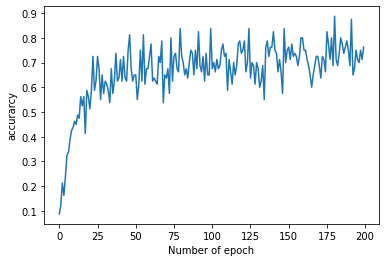

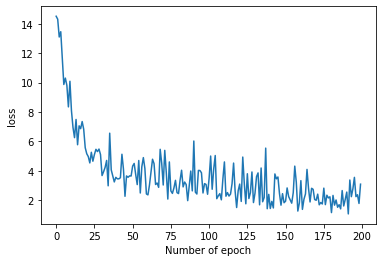

In [25]:
# plot 
plot(accurarcy,"accurarcy")
plot(loss,"loss")

In [26]:
# save weights
with open('Weights_original', 'wb') as file:
    pickle.dump(unaugmented_parameters, file)

### 5.2 Training on augmented data.

In [27]:
# train model on augmented data
augmented_parameters, accurarcy, loss = model(X_train_aug, Y_train_aug, epoch = 300, batch_size = 64 ,learning_rate = 0.001, print_acc = True)

Epoch:1
Loss : 11.998945359956592,   Accuracy: 0.21875
--------------------------------------------

Epoch:2
Loss : 10.164403496218084,   Accuracy: 0.46875
--------------------------------------------

Epoch:3
Loss : 6.433847909205347,   Accuracy: 0.4375
--------------------------------------------

Epoch:4
Loss : 10.896091576722903,   Accuracy: 0.3125
--------------------------------------------

Epoch:5
Loss : 6.5196645942407345,   Accuracy: 0.5
--------------------------------------------

Epoch:6
Loss : 6.767603134738591,   Accuracy: 0.34375
--------------------------------------------

Epoch:7
Loss : 5.277681790538848,   Accuracy: 0.59375
--------------------------------------------

Epoch:8
Loss : 7.850471995948236,   Accuracy: 0.59375
--------------------------------------------

Epoch:9
Loss : 5.099626672309613,   Accuracy: 0.65625
--------------------------------------------

Epoch:10
Loss : 6.797337638777475,   Accuracy: 0.46875
--------------------------------------------

E

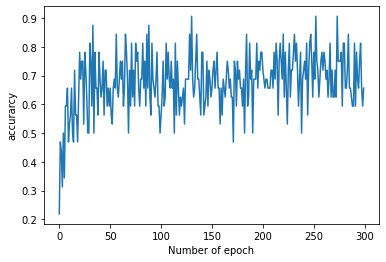

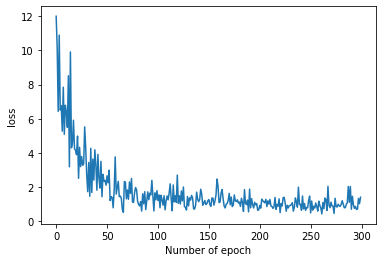

In [28]:
# plot 
plot(accurarcy,"accurarcy")
plot(loss,"loss")

In [29]:
with open('Weights_augmented', 'wb') as file:
    pickle.dump(augmented_parameters, file)

# 6. Evaluate the performance of both model on test set.

### 6.0 Load testing data

In [30]:
# load test data
with open(path + 'x_test_feature', 'rb') as file:
    X_test = pickle.load(file)

with open(path + 'y_test', 'rb') as file:
    Y_test = pickle.load(file)

In [31]:
# function to load weights
def load_weights(file_name):
    with open(file_name, 'rb') as file:
        parameter_dict = pickle.load(file)
    W1 = parameter_dict["W1"]
    b1 = parameter_dict["b1"]
    W2 = parameter_dict["W2"]
    b2 = parameter_dict["b2"]
    return W1, b1, W2, b2

### 6.1 Unaugmented model

In [32]:
# extract weights 
# load weigths
W1, b1, W2, b2 = load_weights("Weights_original")

Y_pred = predict(W1,b1,W2,b2,X_test)
acc = get_accuracy(Y_test,Y_pred)
print("Test accuracy : {}".format(acc))

Test accuracy : 0.679


### 6.2 Augmented model

In [33]:
# load weigths
W1, b1, W2, b2 = load_weights("Weights_augmented")

Y_pred = predict(W1,b1,W2,b2,X_test)
acc = get_accuracy(Y_test,Y_pred)
print("Test accuracy : {}".format(acc))

Test accuracy : 0.689
